In [134]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, Imputer, OneHotEncoder, LabelEncoder
import numpy as np
import seaborn as sns

%matplotlib inline


In [135]:
df = pd.read_csv('data/train.csv',sep=';')
df.head()



,VOIE_DEPOT,COUNTRY,SOURCE_BEGIN_MONTH,APP_NB,APP_NB_PAYS,APP_NB_TYPE,FISRT_APP_COUNTRY,FISRT_APP_TYPE,LANGUAGE_OF_FILLING,FIRST_CLASSE,...,oecd_NB_BACKWARD_NPL,IDX_ORIGIN,SOURCE_IDX_ORI,IDX_RADIC,SOURCE_IDX_RAD,VARIABLE_CIBLE,PRIORITY_MONTH,FILING_MONTH,PUBLICATION_MONTH,BEGIN_MONTH
0,EURO-PCT,US,D0,1,1,1,US,COMPAGNY,en,A61K9/48,...,0.000,1.000000,IMPUT,1.00,IMPUT,GRANTED,09/1995,08/1996,03/1997,09/1995
1,EURO-PCT,DE,D0,1,1,1,DE,COMPAGNY,de,C08G65/26,...,0.000,1.000000,IMPUT,1.00,IMPUT,GRANTED,11/1999,11/2000,05/2001,11/1999
2,VOIE DIRECTE,JP,D0,1,1,1,JP,COMPAGNY,en,G11B15/07,...,0.125,0.897778,CALC,1.00,IMPUT,GRANTED,06/1992,05/1993,12/1993,06/1992
3,VOIE DIRECTE,GB,D0,1,1,1,GB,COMPAGNY,en,F25B41/04,...,0.000,1.000000,IMPUT,1.00,IMPUT,GRANTED,05/1994,05/1995,11/1995,05/1994
4,VOIE DIRECTE,DE,D0,1,1,1,DE,COMPAGNY,de,H01F17/06,...,0.000,0.625000,CALC,0.25,CALC,GRANTED,12/1988,11/1989,06/1990,12/1988


In [136]:
df.dtypes


VOIE_DEPOT               object
COUNTRY                  object
SOURCE_BEGIN_MONTH       object
APP_NB                  float64
APP_NB_PAYS             float64
APP_NB_TYPE             float64
FISRT_APP_COUNTRY        object
FISRT_APP_TYPE           object
LANGUAGE_OF_FILLING      object
FIRST_CLASSE             object
NB_CLASSES                int64
NB_ROOT_CLASSES           int64
NB_SECTORS                int64
NB_FIELDS                 int64
TECHNOLOGIE_SECTOR       object
TECHNOLOGIE_FIELD        object
MAIN_IPC                 object
INV_NB                  float64
INV_NB_PAYS             float64
INV_NB_TYPE             float64
FISRT_INV_COUNTRY        object
FISRT_INV_TYPE           object
cited_n                 float64
cited_nmiss             float64
cited_age_min             int64
cited_age_median        float64
cited_age_max             int64
cited_age_mean          float64
cited_age_std           float64
SOURCE_CITED_AGE         object
NB_BACKWARD_NPL           int64
NB_BACKW

In [137]:
def unique(df):
    for col in df.columns:
        l = len(df[col].unique())
        
        print(col+' : ', l)
        print(df[col].unique())
        print('-----------------------------------------------------')

In [138]:
unique(df)

VOIE_DEPOT :  2
['EURO-PCT' 'VOIE DIRECTE']
-----------------------------------------------------
COUNTRY :  91
['US' 'DE' 'JP' 'GB' 'SE' nan 'IT' 'FR' 'EP' 'NO' 'NL' 'KR' 'CH' 'ES' 'WO'
 'YU' 'CN' 'DD' 'DK' 'AT' 'LU' 'FI' 'IS' 'CA' 'NZ' 'AU' 'IL' 'SG' 'AR' 'RU'
 'CZ' 'UA' 'IE' 'SU' 'BE' 'PL' 'IN' 'BR' 'HU' 'EG' 'SK' 'TR' 'RS' 'BG' 'AL'
 'SI' 'TW' 'ZA' 'LV' 'CU' 'CL' 'RO' 'GR' 'SM' 'EE' 'HK' 'PT' 'HR' 'MX' 'MY'
 'MT' 'IR' 'CO' 'CS' 'UY' 'EC' 'VE' 'SV' 'GE' 'BY' 'LB' 'KZ' 'MC' 'PH' 'TH'
 'BA' 'PK' 'ZW' 'MA' 'KP' 'MD' 'IB' 'EA' 'ML' 'ID' 'LT' 'HN' 'AE' 'TN' 'UZ'
 'JO']
-----------------------------------------------------
SOURCE_BEGIN_MONTH :  3
['D0' 'D1' nan]
-----------------------------------------------------
APP_NB :  16
[  1.   4.   2.   3.   7.  nan   5.   6.   9.  10.  13.   8.  17.  11.  16.
  14.]
-----------------------------------------------------
APP_NB_PAYS :  9
[  1.   2.   3.  nan   4.   5.   0.   7.  12.]
-----------------------------------------------------
APP_NB_TYP

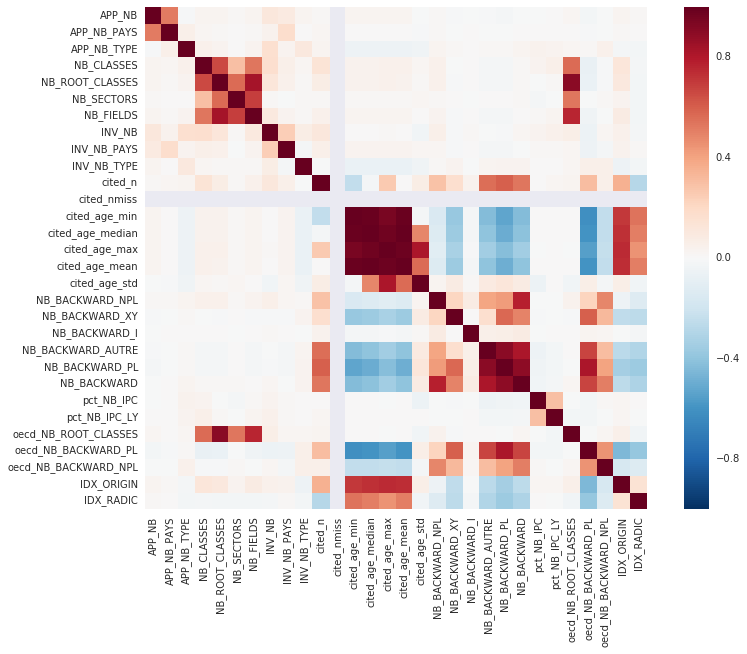

In [139]:
plt.figure(figsize=(13,9))
corr = df.corr()
sns.heatmap(corr, square=True)

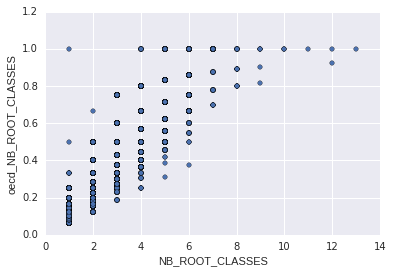

In [55]:
df.plot(kind='scatter', y='oecd_NB_ROOT_CLASSES', x='NB_ROOT_CLASSES')

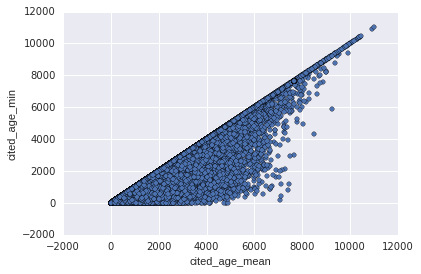

In [56]:
df.plot(kind='scatter', y='cited_age_min', x='cited_age_mean')

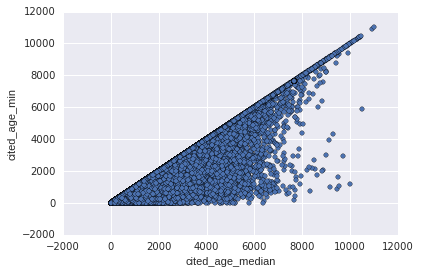

In [57]:
df.plot(kind='scatter', y='cited_age_min', x='cited_age_median')

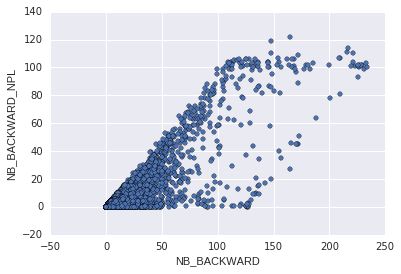

In [58]:
df.plot(kind='scatter', y='NB_BACKWARD_NPL', x='NB_BACKWARD')

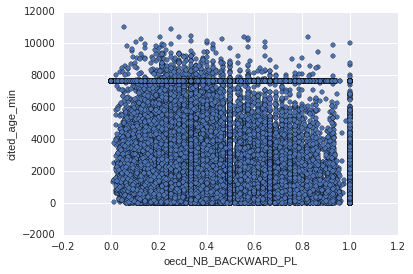

In [59]:
df.plot(kind='scatter', y='cited_age_min', x='oecd_NB_BACKWARD_PL')

# preprocessings

In [140]:
df = df.drop('cited_nmiss', axis=1) # because only 2 values : 0 and Nan 

# dropping columns containing too many categories
df = df.drop(['FISRT_APP_COUNTRY', 'FIRST_CLASSE', 'TECHNOLOGIE_FIELD', 'MAIN_IPC', 'FISRT_INV_COUNTRY'], axis=1)


def binarizer(x,string):
    if x == string:
        return 1
    else:
        return 0

df.VARIABLE_CIBLE = df.VARIABLE_CIBLE.apply(lambda row : binarizer(row,'GRANTED'))
df.SOURCE_IDX_RAD = df.SOURCE_IDX_RAD.apply(lambda row : binarizer(row,'CALC'))
df.SOURCE_IDX_ORI = df.SOURCE_IDX_ORI.apply(lambda row : binarizer(row,'CALC'))
df.SOURCE_CITED_AGE = df.SOURCE_CITED_AGE.apply(lambda row : binarizer(row,'CALC'))
df.VOIE_DEPOT = df.VOIE_DEPOT.apply(lambda row : binarizer(row,'VOIE DIRECTE'))

In [141]:
print(df.SOURCE_BEGIN_MONTH.unique())
df.SOURCE_BEGIN_MONTH = df.SOURCE_BEGIN_MONTH.str.extract('^D([0-1])').astype('float')
print(df.SOURCE_BEGIN_MONTH.unique())

['D0' 'D1' nan]
[  0.   1.  nan]


In [142]:
# extracting the month in date strings:

columns = ['PRIORITY_MONTH', 'FILING_MONTH', 'PUBLICATION_MONTH', 'BEGIN_MONTH']

for col in columns:
    df[col] = df[col].str.extract('^([0-9]{2})').astype('float')

In [143]:
print(len(df))
cols = df.columns

# selecting numerical and strings columns:
string_cols = []
categorical_num_cols = []
continuous_num_cols = []

for col in cols:
    if df[col].dtype == 'object':
        string_cols.append(col)
    elif df[col].dtype in ['float64', 'int64']:
        if len(df[col].unique()) > 40:
            continuous_num_cols.append(col)
        else:
            categorical_num_cols.append(col)
        

data_categorical_num = df[categorical_num_cols].values
data_continuous_num = df[continuous_num_cols].values
data_string = df[string_cols].values

print(categorical_num_cols)
print(continuous_num_cols)
print(string_cols)


print(data_categorical_num)
print(data_continuous_num)

259431
['VOIE_DEPOT', 'SOURCE_BEGIN_MONTH', 'APP_NB', 'APP_NB_PAYS', 'APP_NB_TYPE', 'NB_CLASSES', 'NB_ROOT_CLASSES', 'NB_SECTORS', 'NB_FIELDS', 'INV_NB', 'INV_NB_PAYS', 'INV_NB_TYPE', 'SOURCE_CITED_AGE', 'NB_BACKWARD_I', 'SOURCE_IDX_ORI', 'SOURCE_IDX_RAD', 'VARIABLE_CIBLE', 'PRIORITY_MONTH', 'FILING_MONTH', 'PUBLICATION_MONTH', 'BEGIN_MONTH']
['cited_n', 'cited_age_min', 'cited_age_median', 'cited_age_max', 'cited_age_mean', 'cited_age_std', 'NB_BACKWARD_NPL', 'NB_BACKWARD_XY', 'NB_BACKWARD_AUTRE', 'NB_BACKWARD_PL', 'NB_BACKWARD', 'pct_NB_IPC', 'pct_NB_IPC_LY', 'oecd_NB_ROOT_CLASSES', 'oecd_NB_BACKWARD_PL', 'oecd_NB_BACKWARD_NPL', 'IDX_ORIGIN', 'IDX_RADIC']
['COUNTRY', 'FISRT_APP_TYPE', 'LANGUAGE_OF_FILLING', 'TECHNOLOGIE_SECTOR', 'FISRT_INV_TYPE']
[[  0.   0.   1. ...,   8.   3.   9.]
 [  0.   0.   1. ...,  11.   5.  11.]
 [  1.   0.   1. ...,   5.  12.   6.]
 ..., 
 [  1.   0.   1. ...,  12.   7.  12.]
 [  0.   0.   1. ...,   9.   3.   9.]
 [  0.   0.   2. ...,  11.   6.  12.]]
[[   

In [144]:
# filling Nan in continuous numerical columns :
imputer_continuous = Imputer(missing_values='NaN', strategy='median', axis=0)

imputer_continuous.fit(data_continuous_num)
data_continuous_num = imputer_continuous.transform(data_continuous_num)

df1 = pd.DataFrame(data_continuous_num, columns=continuous_num_cols)

print(len(df1.dropna()))

259431


In [145]:
# filling Nan in categorical numerical columns :
imputer_categorical = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

imputer_categorical.fit(data_categorical_num)
data_categorical_num = imputer_categorical.transform(data_categorical_num)

df2 = pd.DataFrame(data_categorical_num, columns=categorical_num_cols)

print(len(df2.dropna()))

259431


In [146]:
# rebuilding dataFrame :
print(len(df1),len(df2),len(df3))
df3 = pd.DataFrame(data_string, columns=string_cols)
df = pd.concat([df1,df2,df3],axis=1)
print(len(df))

259431 259431 259431
259431


In [147]:
unique(df)

cited_n :  58
[  2.   6.   4.   3.   1.   5.  12.  14.   7.   8.   9.  11.  10.  31.  23.
  19.  25.  13.  64.  16.  18.  65.  15.  24.  36.  38.  21.  22.  29.  44.
  35.  40.  32.  27.  47.  61.  30.  59.  28.  48.  20.  73.  50.  26.  49.
  17.  37.  66.  45.  39.  41.  52.  33.  89.  46.  43.  34.  51.]
-----------------------------------------------------
cited_age_min :  6911
[ 7665.   256.   709. ...,  8792.  6984.  3803.]
-----------------------------------------------------
cited_age_median :  11544
[ 7665.   1147.   1541.5 ...,  5518.5  6984.   5160.5]
-----------------------------------------------------
cited_age_max :  8359
[ 7665.  3365.  2374. ...,  8792.  9149.  8001.]
-----------------------------------------------------
cited_age_mean :  21436
[ 7665.         1371.1666667  1541.5       ...,  1796.6666667  5160.5
  5251.6666667]
-----------------------------------------------------
cited_age_std :  27190
[  802.56619665  1188.2685583   1177.3327907  ...,   271.13895576

In [149]:
df = df.dropna()
print(len(df))

237371


In [75]:
df.head()

,cited_n,cited_age_min,cited_age_median,cited_age_max,cited_age_mean,cited_age_std,NB_BACKWARD_NPL,NB_BACKWARD_XY,NB_BACKWARD_AUTRE,NB_BACKWARD_PL,...,VARIABLE_CIBLE,PRIORITY_MONTH,FILING_MONTH,PUBLICATION_MONTH,BEGIN_MONTH,COUNTRY,FISRT_APP_TYPE,LANGUAGE_OF_FILLING,TECHNOLOGIE_SECTOR,FISRT_INV_TYPE
0,2,7665,7665.0,7665,7665.000000,802.566197,0,0,0,0,...,1,9,8,3,9,US,COMPAGNY,en,III - Chemistry,(MISSING)
1,2,7665,7665.0,7665,7665.000000,802.566197,0,0,0,0,...,1,11,11,5,11,DE,COMPAGNY,de,III - Chemistry,(MISSING)
2,6,256,1147.0,3365,1371.166667,1188.268558,1,3,8,11,...,1,6,5,12,6,JP,COMPAGNY,en,I - Electrical engineering,COMPAGNY
3,2,7665,7665.0,7665,7665.000000,802.566197,0,3,0,3,...,1,5,5,11,5,GB,COMPAGNY,en,IV - Mechanical engineering,(MISSING)
4,2,709,1541.5,2374,1541.500000,1177.332791,0,0,6,6,...,1,12,11,6,12,DE,COMPAGNY,de,I - Electrical engineering,(MISSING)


In [150]:
# Encoding categorical features (in string type columns) :

LabEnc = {}
for col in string_cols:
    print(col)
    le = LabelEncoder()
    le.fit(df[col].values)
    df[col] = le.transform(df[col].values)
    
    LabEnc[col] = le


COUNTRY
FISRT_APP_TYPE
LANGUAGE_OF_FILLING
TECHNOLOGIE_SECTOR
FISRT_INV_TYPE


In [99]:
unique(df)

VOIE_DEPOT :  1
[1]
-----------------------------------------------------
COUNTRY :  52
[32 13 22 31 48 21 18  7 37 36 42 49 20 14  3 33  9  4 19  6 28 41  2  5 27
  1 51 26 39 47 43 40 34 29 16 38 44 17 23 12 10 46 11 35 30 25 50 24 45 15
  8  0]
-----------------------------------------------------
SOURCE_BEGIN_MONTH :  1
[ 0.]
-----------------------------------------------------
APP_NB :  11
[  1.   2.   3.   5.   4.   6.   8.   9.  13.   7.  14.]
-----------------------------------------------------
APP_NB_PAYS :  5
[  1.   2.   3.   4.  12.]
-----------------------------------------------------
APP_NB_TYPE :  4
[ 1.  0.  2.  3.]
-----------------------------------------------------
FISRT_APP_TYPE :  5
[1 0 4 2 3]
-----------------------------------------------------
LANGUAGE_OF_FILLING :  17
[ 4  2  7  9 15  5 11  6 12 10  1 14 16  8  0  3 13]
-----------------------------------------------------
NB_CLASSES :  24
[ 4  1  2  5  3  9  6 11 10  8 12  7 13 15 16 14 28 19 21 17 18 23 

In [151]:

OneHot = OneHotEncoder(sparse=False)
OneHot.fit(df[string_cols].values)
temp = OneHot.transform(df[string_cols].values)

print(np.shape(temp))

cat_cols = []
for j in range(len(string_cols)):
    for i in range(OneHot.feature_indices_[j+1]-OneHot.feature_indices_[j]):
        cat_cols.append(string_cols[j]+'_'+str(i))

df_temp = pd.DataFrame(temp, columns=cat_cols)
print(len(df_temp))
df = pd.concat([df, df_temp], axis=1, join='inner')
df = df.drop(string_cols,axis=1)

df.head()

(237371, 131)
237371


,cited_n,cited_age_min,cited_age_median,cited_age_max,cited_age_mean,cited_age_std,NB_BACKWARD_NPL,NB_BACKWARD_XY,NB_BACKWARD_AUTRE,NB_BACKWARD_PL,...,TECHNOLOGIE_SECTOR_0,TECHNOLOGIE_SECTOR_1,TECHNOLOGIE_SECTOR_2,TECHNOLOGIE_SECTOR_3,TECHNOLOGIE_SECTOR_4,FISRT_INV_TYPE_0,FISRT_INV_TYPE_1,FISRT_INV_TYPE_2,FISRT_INV_TYPE_3,FISRT_INV_TYPE_4
0,2,7665,7665.0,7665,7665.000000,802.566197,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,2,7665,7665.0,7665,7665.000000,802.566197,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,6,256,1147.0,3365,1371.166667,1188.268558,1,3,8,11,...,1,0,0,0,0,0,1,0,0,0
3,2,7665,7665.0,7665,7665.000000,802.566197,0,3,0,3,...,0,0,0,1,0,1,0,0,0,0
4,2,709,1541.5,2374,1541.500000,1177.332791,0,0,6,6,...,1,0,0,0,0,1,0,0,0,0


In [115]:
unique(df)

VOIE_DEPOT :  1
[1]
-----------------------------------------------------
SOURCE_BEGIN_MONTH :  1
[ 0.]
-----------------------------------------------------
APP_NB :  6
[ 1.  2.  3.  5.  4.  6.]
-----------------------------------------------------
APP_NB_PAYS :  4
[ 1.  2.  3.  4.]
-----------------------------------------------------
APP_NB_TYPE :  3
[ 1.  0.  2.]
-----------------------------------------------------
NB_CLASSES :  20
[ 4  1  2  5  3  9  6 11 10  8 12  7 13 15 16 14 28 19 21 17]
-----------------------------------------------------
NB_ROOT_CLASSES :  7
[1 2 3 4 6 5 7]
-----------------------------------------------------
NB_SECTORS :  4
[1 2 3 4]
-----------------------------------------------------
NB_FIELDS :  5
[1 2 3 4 5]
-----------------------------------------------------
INV_NB :  18
[  9.   1.   5.   4.  10.   2.   6.   3.   7.   8.  12.  13.  16.  15.  11.
  14.  24.  25.]
-----------------------------------------------------
INV_NB_PAYS :  5
[ 1.  2.  3.  

In [152]:
print(len(df))
df = df.dropna()
print(len(df))

217255
217255


In [81]:
df.head()

,cited_n,cited_age_min,cited_age_median,cited_age_max,cited_age_mean,cited_age_std,NB_BACKWARD_NPL,NB_BACKWARD_XY,NB_BACKWARD_AUTRE,NB_BACKWARD_PL,...,TECHNOLOGIE_SECTOR_0,TECHNOLOGIE_SECTOR_1,TECHNOLOGIE_SECTOR_2,TECHNOLOGIE_SECTOR_3,TECHNOLOGIE_SECTOR_4,FISRT_INV_TYPE_0,FISRT_INV_TYPE_1,FISRT_INV_TYPE_2,FISRT_INV_TYPE_3,FISRT_INV_TYPE_4
0,2,7665,7665.0,7665,7665.000000,802.566197,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,2,7665,7665.0,7665,7665.000000,802.566197,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,6,256,1147.0,3365,1371.166667,1188.268558,1,3,8,11,...,1,0,0,0,0,0,1,0,0,0
3,2,7665,7665.0,7665,7665.000000,802.566197,0,3,0,3,...,0,0,0,1,0,1,0,0,0,0
4,2,709,1541.5,2374,1541.500000,1177.332791,0,0,6,6,...,1,0,0,0,0,1,0,0,0,0


In [82]:
df.describe()

,cited_n,cited_age_min,cited_age_median,cited_age_max,cited_age_mean,cited_age_std,NB_BACKWARD_NPL,NB_BACKWARD_XY,NB_BACKWARD_AUTRE,NB_BACKWARD_PL,...,TECHNOLOGIE_SECTOR_0,TECHNOLOGIE_SECTOR_1,TECHNOLOGIE_SECTOR_2,TECHNOLOGIE_SECTOR_3,TECHNOLOGIE_SECTOR_4,FISRT_INV_TYPE_0,FISRT_INV_TYPE_1,FISRT_INV_TYPE_2,FISRT_INV_TYPE_3,FISRT_INV_TYPE_4
count,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,...,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000,217255.000000
mean,2.004161,5604.765511,5743.722046,5921.639267,5754.462087,839.329430,0.557575,0.871906,1.842144,2.715671,...,0.247032,0.154542,0.278194,0.252372,0.067860,0.913028,0.083128,0.000446,0.000184,0.003213
std,0.994809,2987.623627,2806.017052,2631.718385,2787.347630,372.186398,2.978328,1.736921,3.448240,4.129796,...,0.431287,0.361468,0.448110,0.434374,0.251507,0.281794,0.276076,0.021125,0.013568,0.056591
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2002.000000,2567.750000,3368.000000,2598.500000,802.566197,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,7665.000000,7665.000000,7665.000000,7665.000000,802.566197,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,7665.000000,7665.000000,7665.000000,7665.000000,802.566197,0.000000,1.000000,3.000000,5.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,66.000000,10898.000000,10898.000000,11305.000000,10898.000000,6619.226579,122.000000,70.000000,131.000000,134.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
# standardization of columns :
standardize = StandardScaler()
normalized_cols = ['cited_age_min', 'cited_age_median', 'cited_age_max', 'cited_age_mean', 'cited_age_std']

dat = df[normalized_cols].values
standardize.fit(dat)

dat = standardize.transform(dat)

print(len(df))
df_temp = pd.DataFrame(dat, columns=normalized_cols)
df = df.drop(normalized_cols, axis=1)

df = pd.concat([df, df_temp], axis=1, join='inner')
print(len(df))

217255
198878


In [33]:
unique(df)

cited_n :  45
[  2.   6.   4.   3.   1.   5.  14.   7.   8.   9.  11.  10.  31.  23.  19.
  25.  13.  64.  16.  12.  65.  18.  15.  24.  36.  38.  21.  22.  29.  44.
  35.  40.  32.  30.  59.  28.  48.  20.  26.  37.  17.  66.  41.  27.  52.]
-----------------------------------------------------
NB_BACKWARD_NPL :  109
[   0.    1.    4.    2.    3.   12.   45.    6.    5.    8.   25.   43.
   13.   18.   60.   65.    7.   59.   10.   51.   14.    9.  104.   11.
   20.   93.   98.   53.  102.   19.   50.   68.   15.   44.   16.   62.
   58.   72.   23.   30.   24.   82.  101.   73.   21.   27.  100.   17.
  103.   99.   97.  106.   52.   64.   31.   26.   85.   90.   63.   95.
  119.   84.   47.   35.   34.   32.   22.   28.  109.   33.   29.   56.
   41.   39.   88.   87.   42.   48.   55.   83.   86.   67.   36.  122.
   80.   57.   69.   79.   37.   74.   89.   94.   81.   70.   46.  105.
  111.   54.   78.   40.   38.   71.  110.   92.   49.   76.  114.   91.
  107.]
---------------

In [34]:
df.describe()

,cited_n,NB_BACKWARD_NPL,NB_BACKWARD_XY,NB_BACKWARD_AUTRE,NB_BACKWARD_PL,NB_BACKWARD,pct_NB_IPC,pct_NB_IPC_LY,oecd_NB_ROOT_CLASSES,oecd_NB_BACKWARD_PL,...,FISRT_INV_TYPE_0,FISRT_INV_TYPE_1,FISRT_INV_TYPE_2,FISRT_INV_TYPE_3,FISRT_INV_TYPE_4,cited_age_min,cited_age_median,cited_age_max,cited_age_mean,cited_age_std
count,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,...,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000,198878.000000
mean,2.003947,0.558106,0.870770,1.841466,2.713845,3.271951,0.861242,0.757905,0.222583,0.189626,...,0.913243,0.082910,0.000422,0.000196,0.003228,0.000887,0.000830,0.000691,0.000819,-0.000643
std,0.987779,2.996828,1.736798,3.470568,4.148274,6.077928,0.181105,0.168062,0.119860,0.234382,...,0.281479,0.275747,0.020547,0.014002,0.056725,0.999672,0.999760,0.999831,0.999761,0.997652
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002430,0.004604,0.062500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.875999,-2.046935,-2.250109,-2.064499,-2.255137
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.783312,0.664180,0.142857,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,-1.204561,-1.130643,-0.968434,-1.130387,-0.098777
50%,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.941441,0.786010,0.166667,0.071429,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.689591,0.684701,0.662444,0.685434,-0.098777
75%,2.000000,0.000000,1.000000,3.000000,5.000000,5.000000,1.000000,0.886735,0.285714,0.333333,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.689591,0.684701,0.662444,0.685434,-0.098777
max,66.000000,122.000000,70.000000,131.000000,134.000000,234.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.771725,1.836870,2.045573,1.845321,15.529612


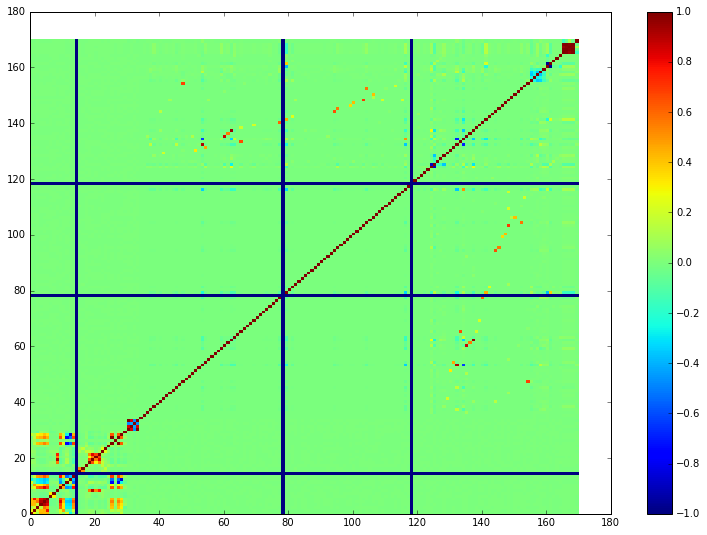

In [44]:
from numpy import corrcoef
from pylab import pcolor, colorbar

plt.figure(figsize=(13,9))
corr = df.corr()
pcolor(corr, vmin=-1, vmax=1)
colorbar()

# Spliting Data

In [153]:
from sklearn.cross_validation import train_test_split

Xcolumns = df.columns.tolist()
Xcolumns.remove('VARIABLE_CIBLE')

X = df[Xcolumns].values
Y = df['VARIABLE_CIBLE'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [154]:
def plot_roc(Y_test, Y_prob):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_prob)
    roc_auc = roc_auc_score(Y_test, Y_prob)

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')

# visualisation

In [ ]:
df.hist('VARIABLE_CIBLE')

/home/maxime/local/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


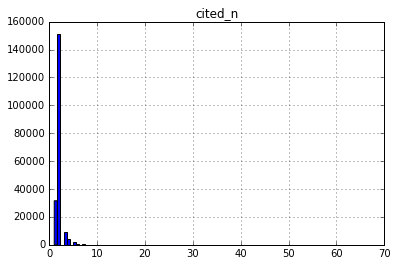

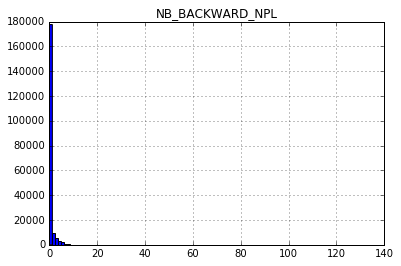

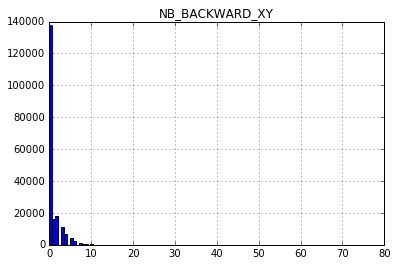

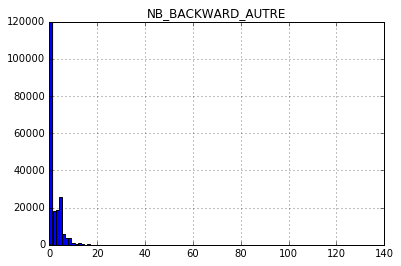

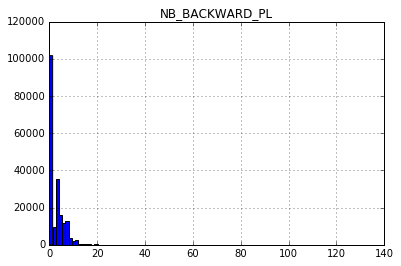

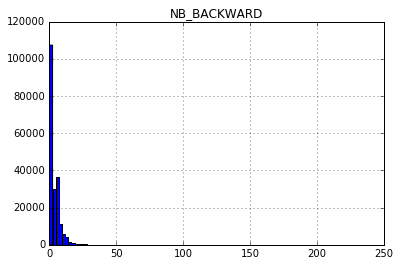

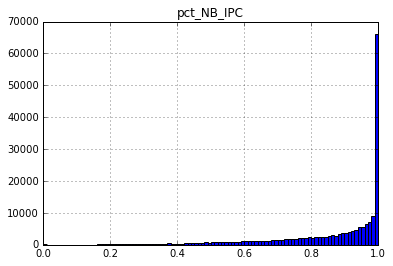

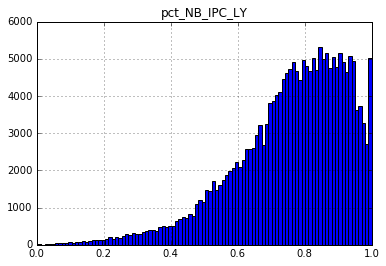

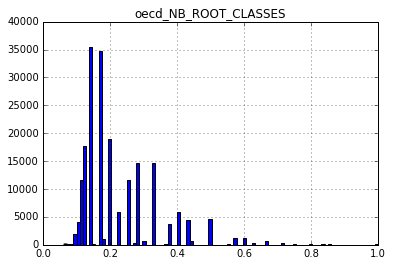

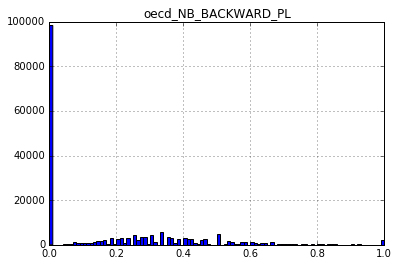

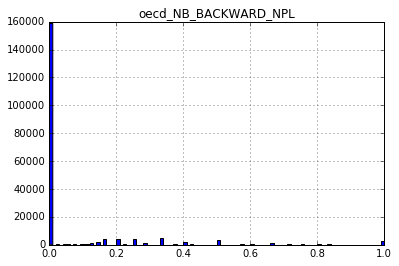

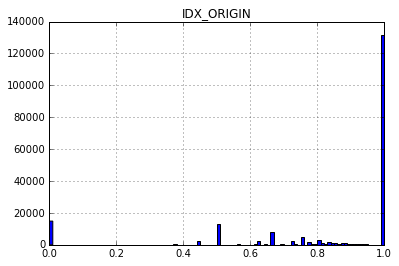

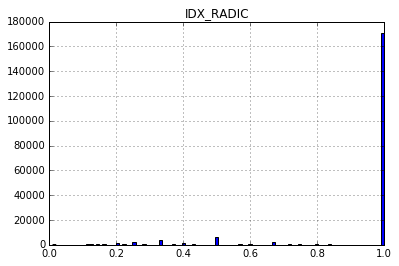

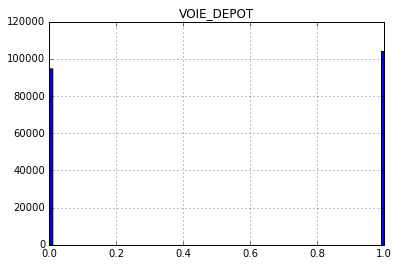

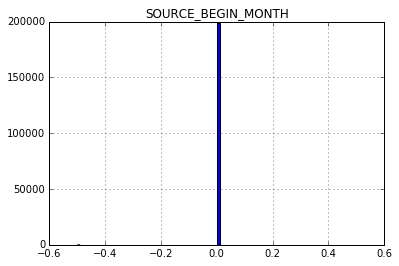

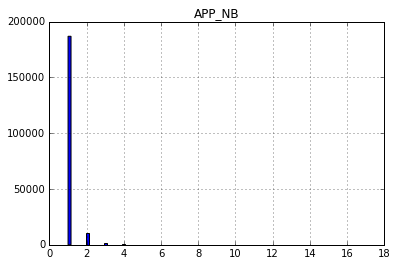

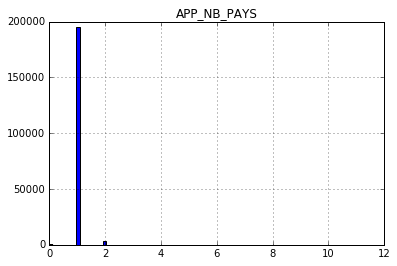

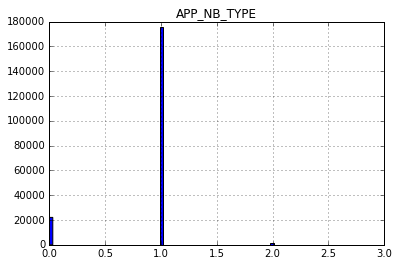

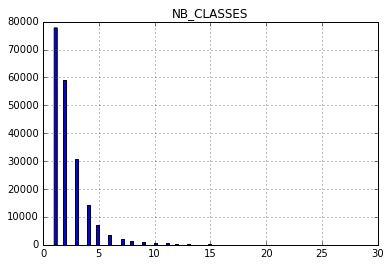

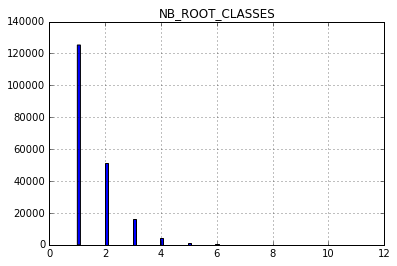

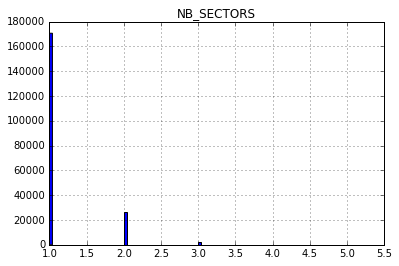

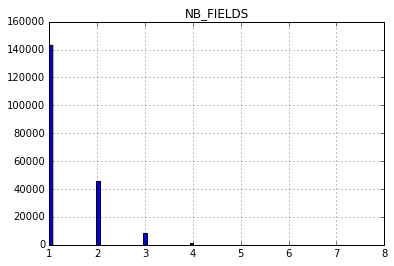

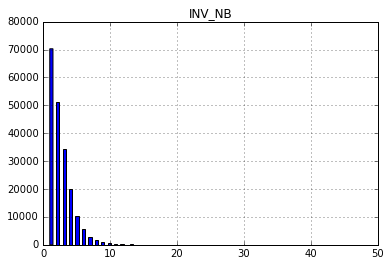

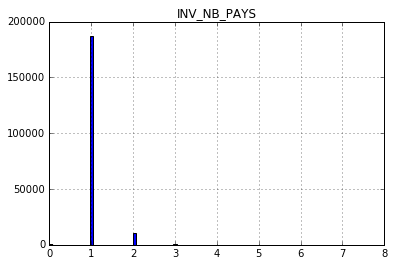

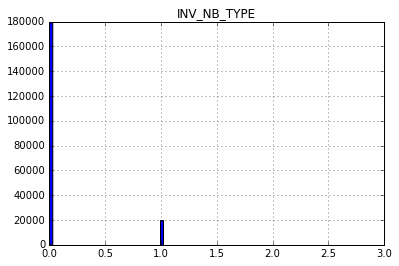

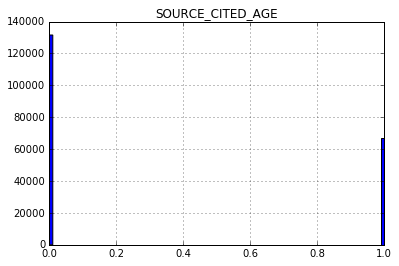

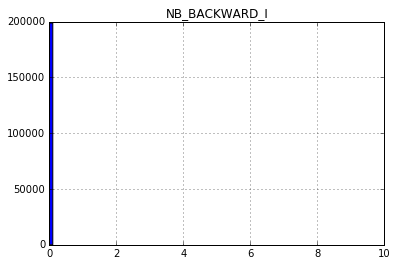

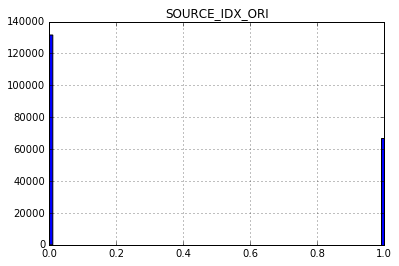

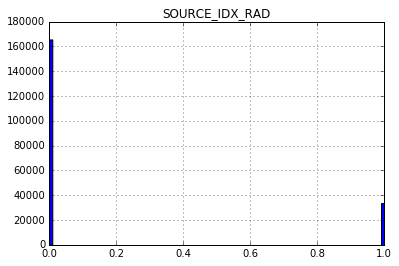

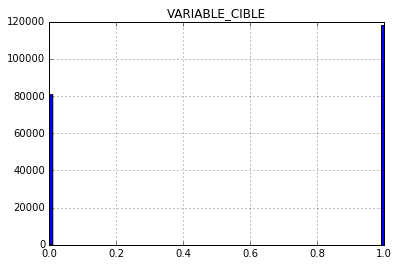

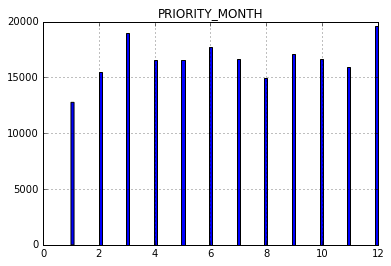

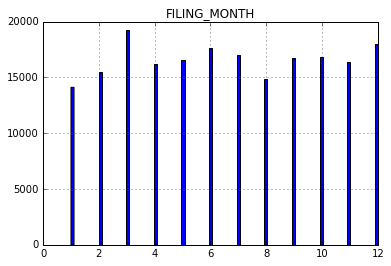

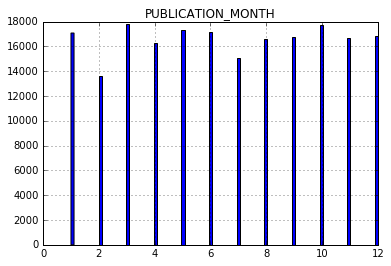

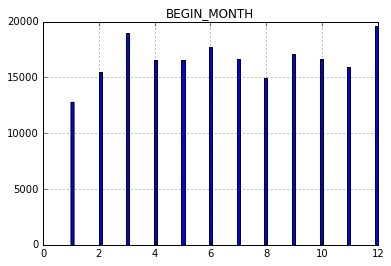

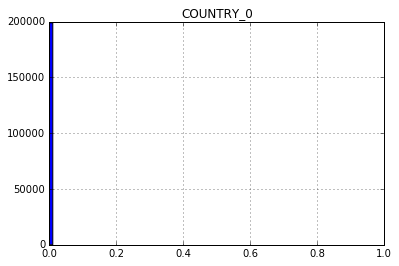

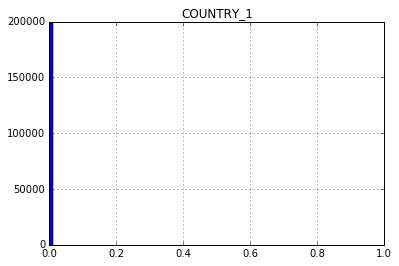

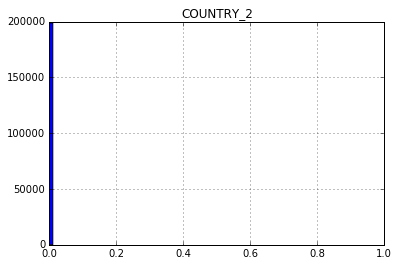

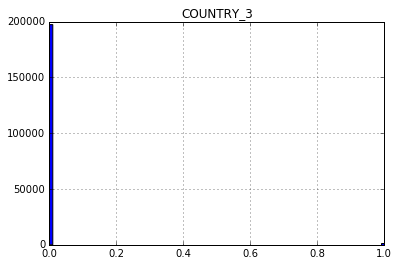

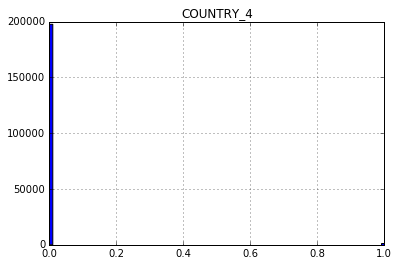

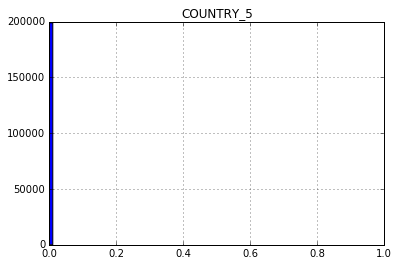

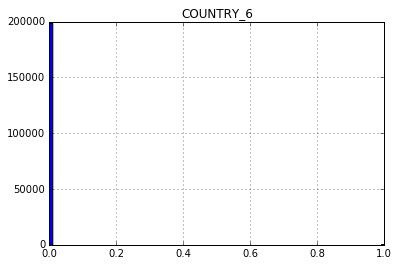

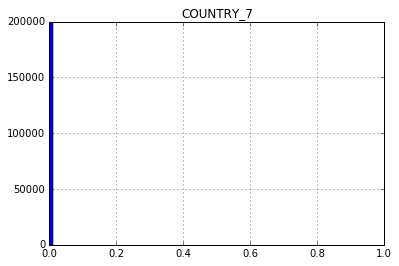

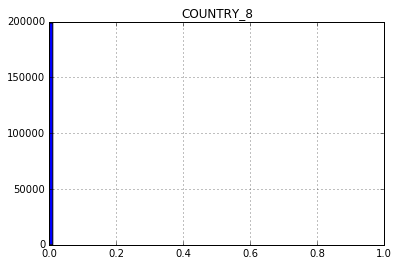

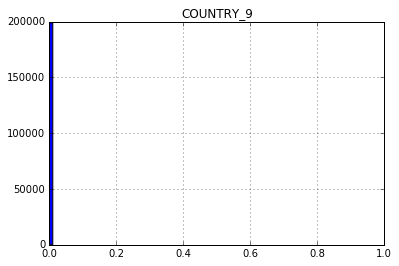

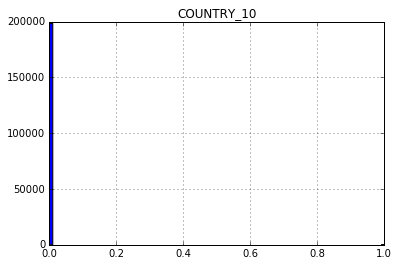

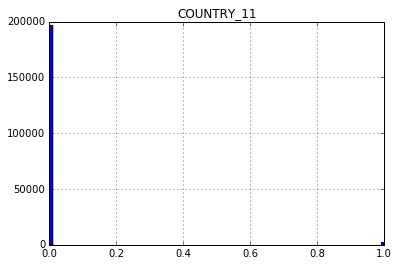

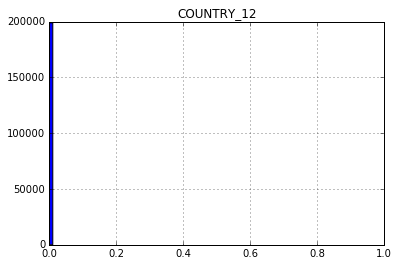

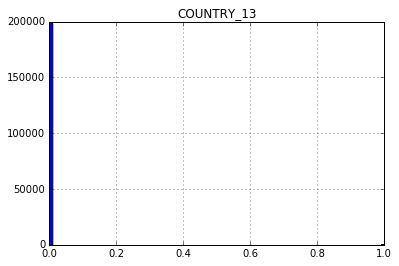

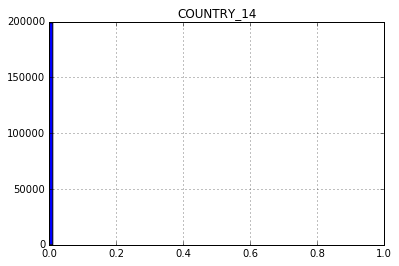

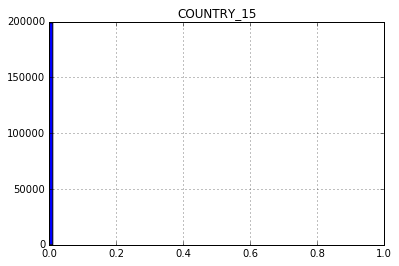

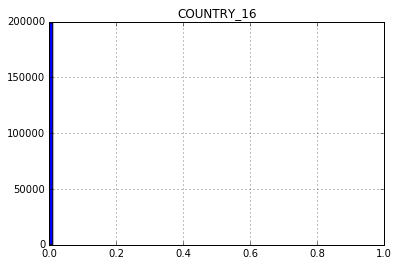

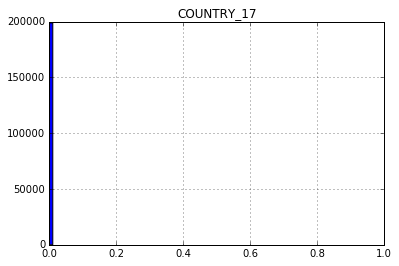

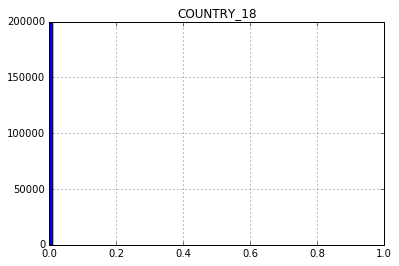

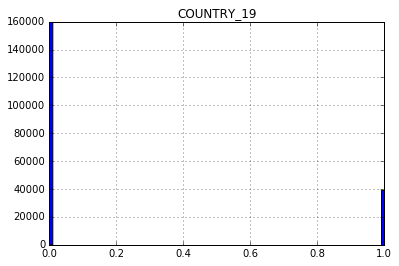

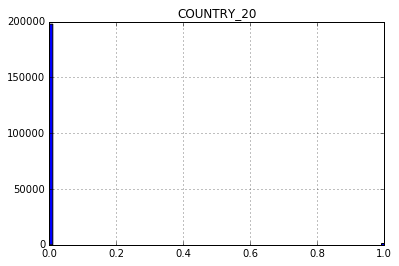

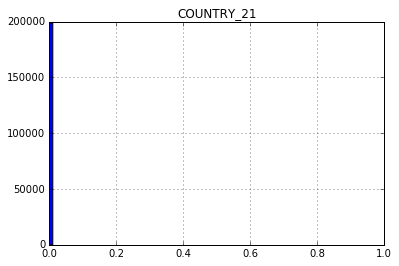

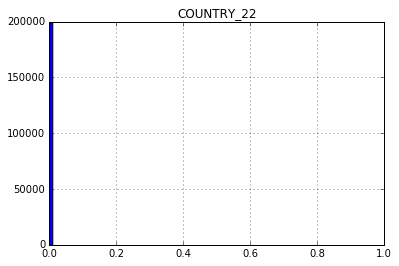

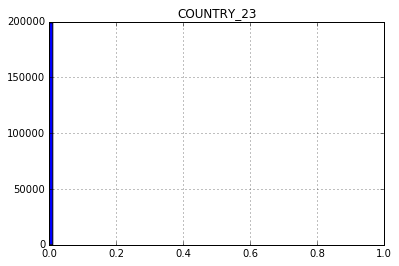

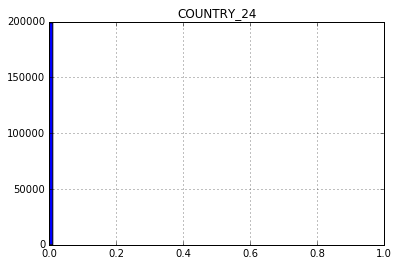

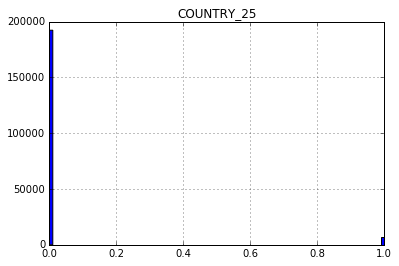

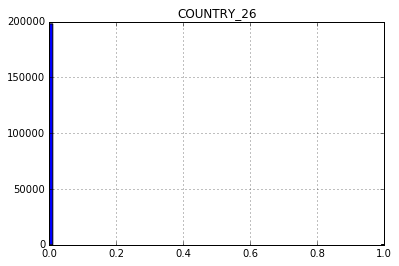

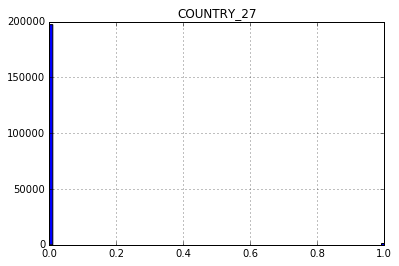

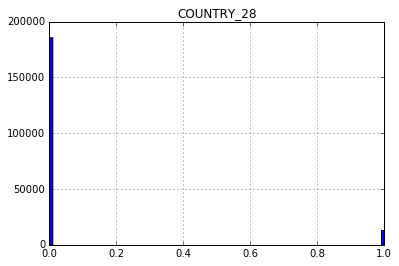

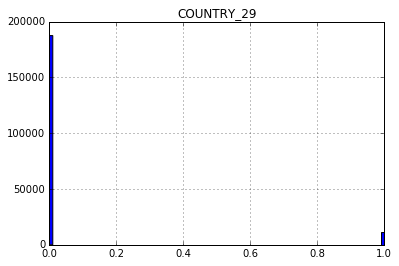

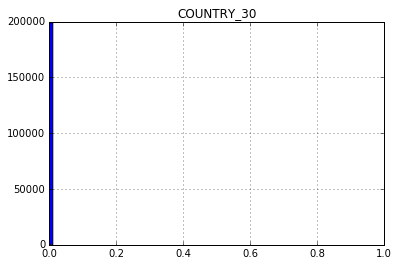

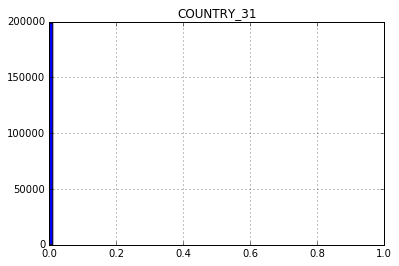

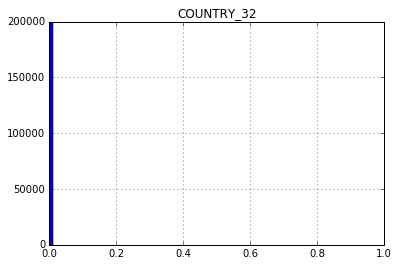

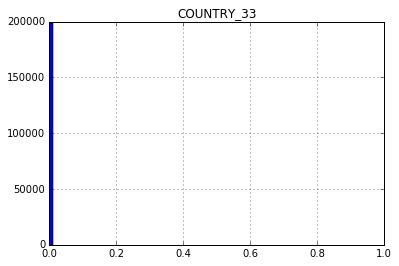

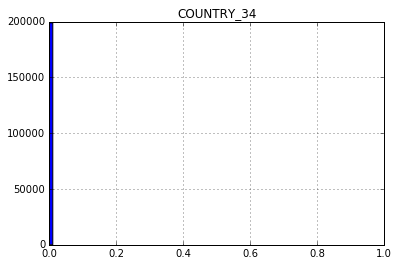

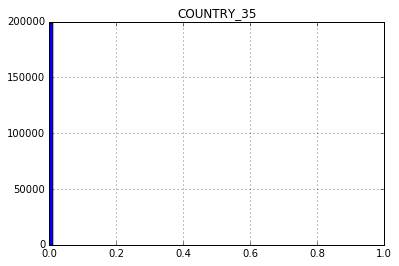

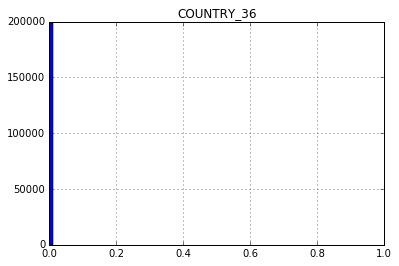

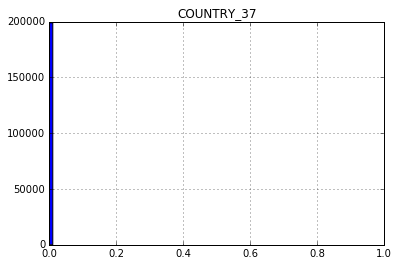

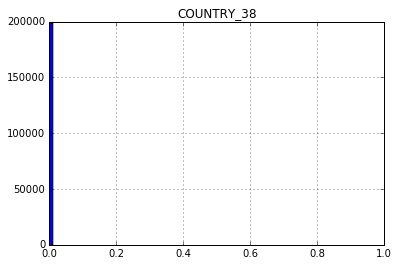

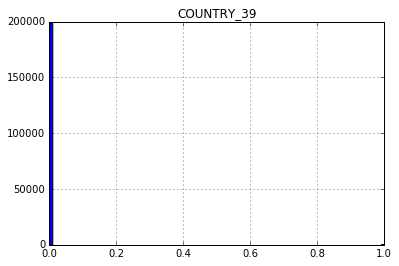

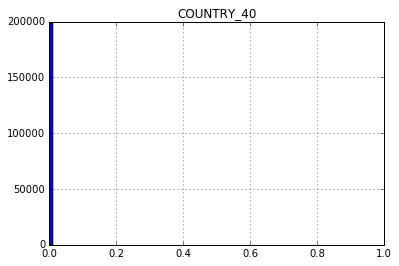

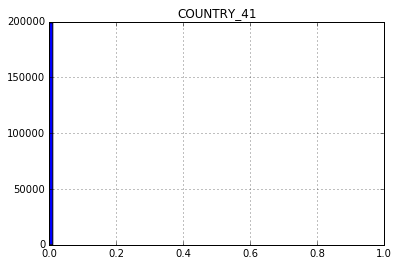

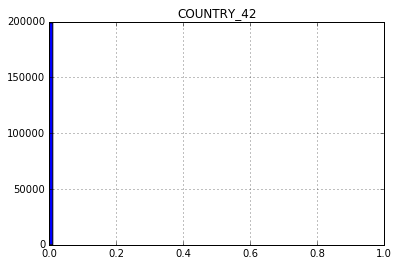

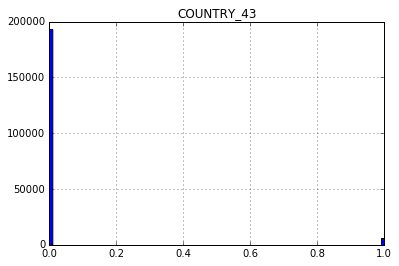

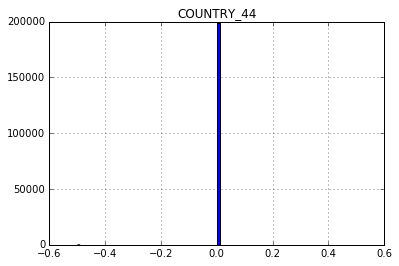

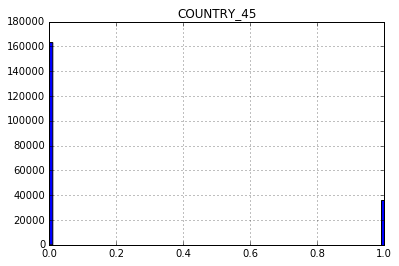

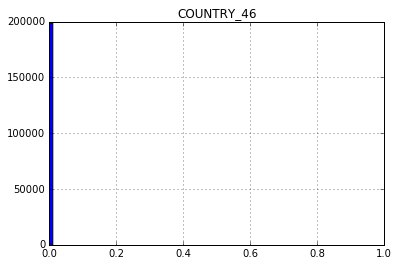

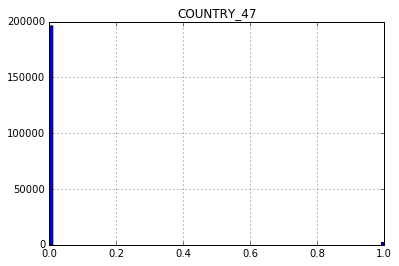

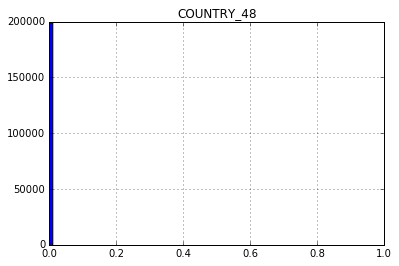

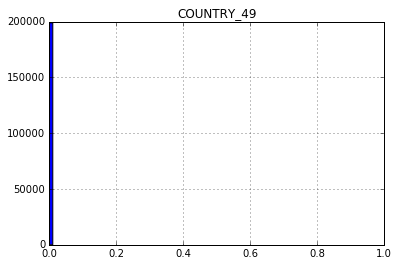

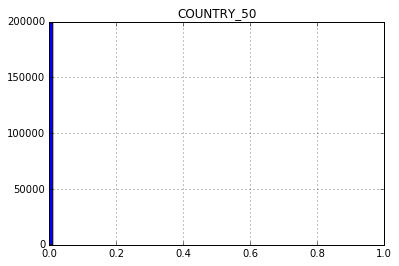

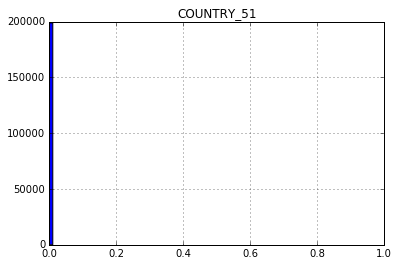

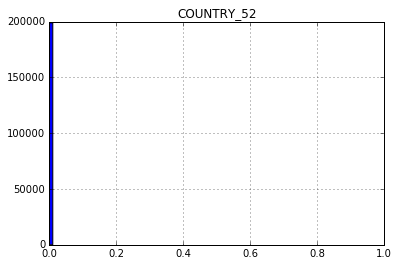

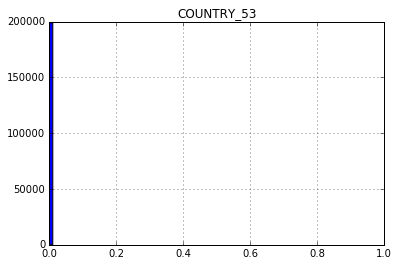

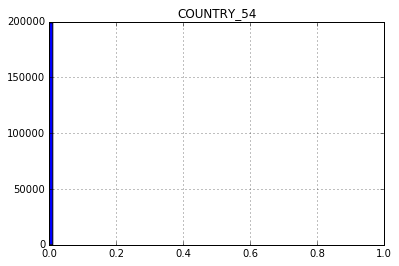

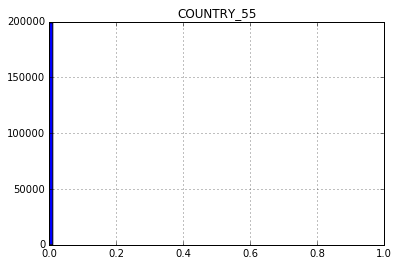

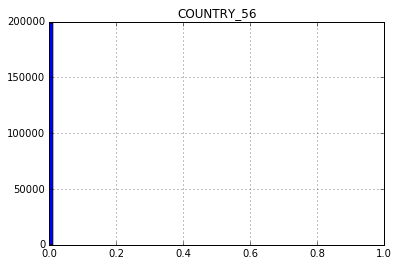

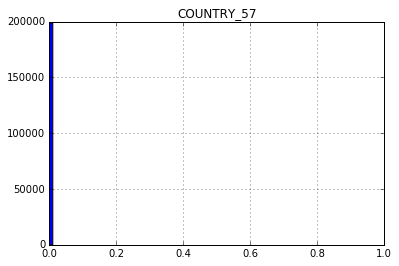

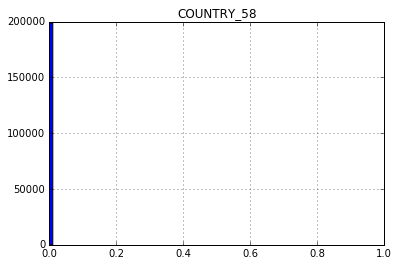

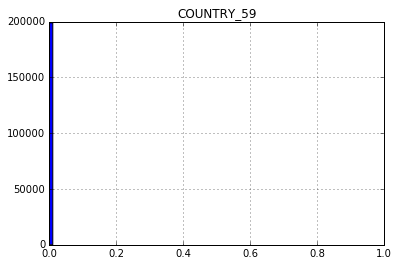

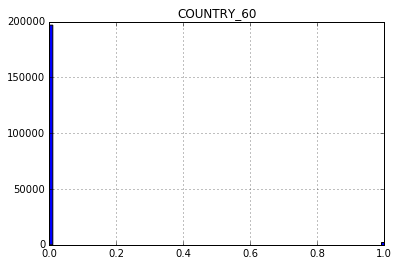

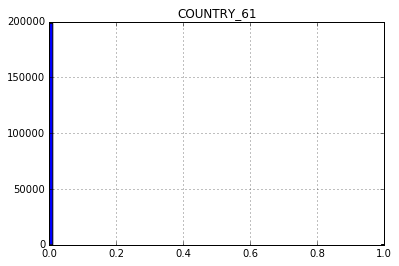

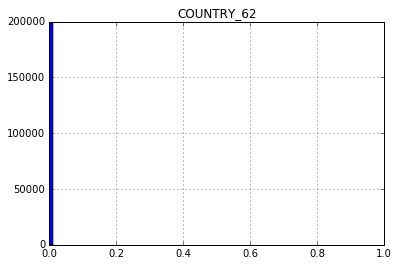

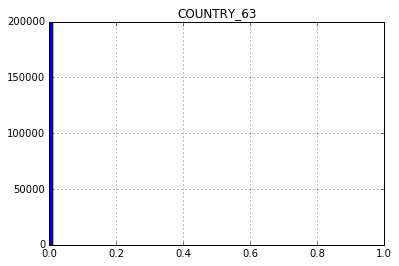

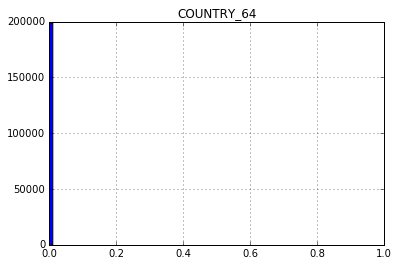

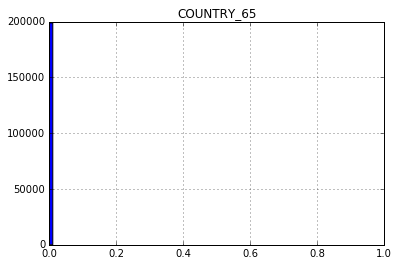

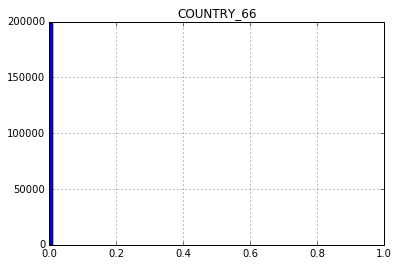

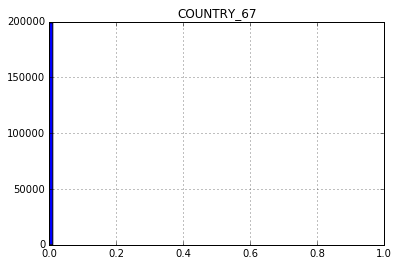

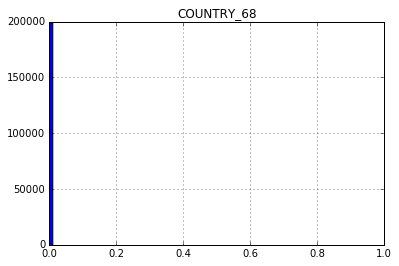

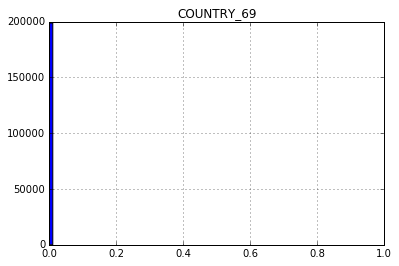

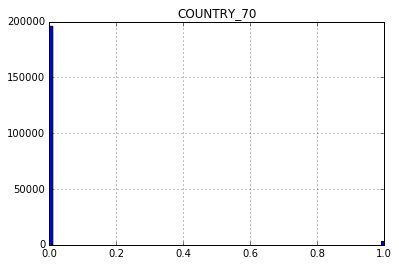

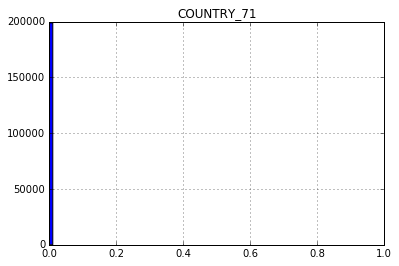

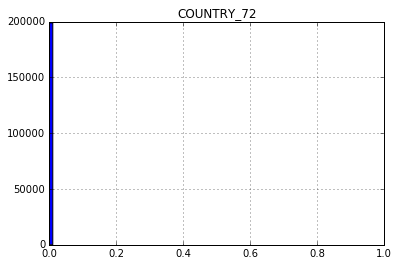

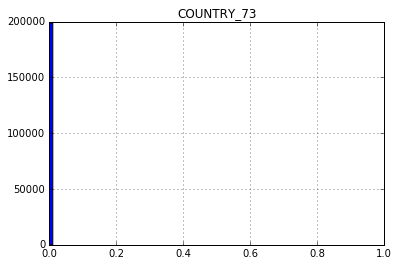

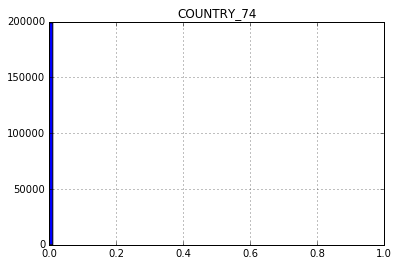

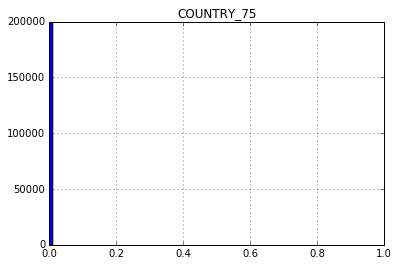

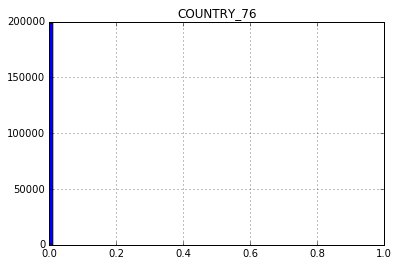

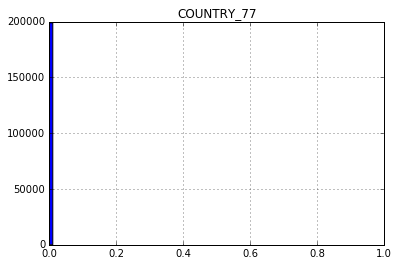

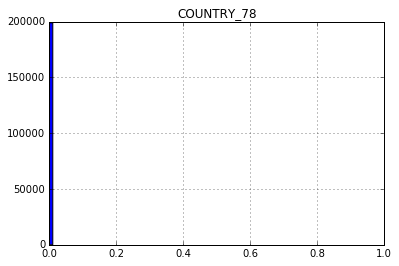

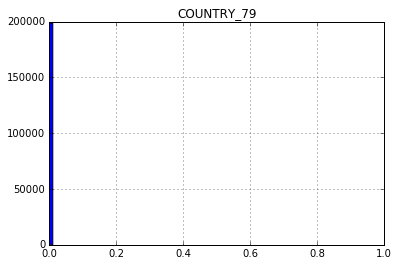

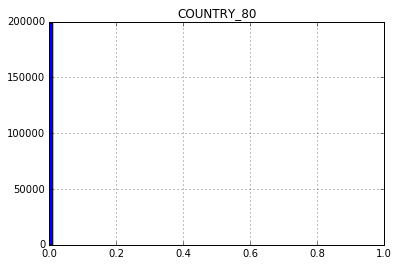

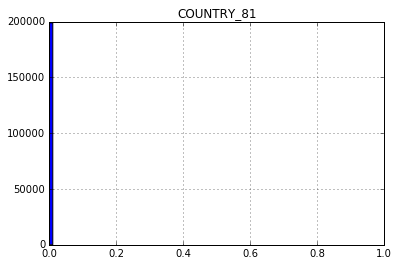

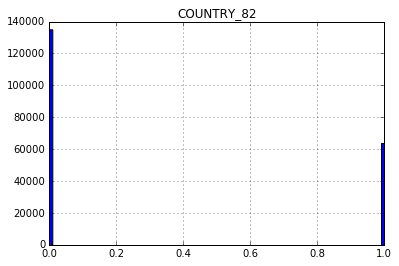

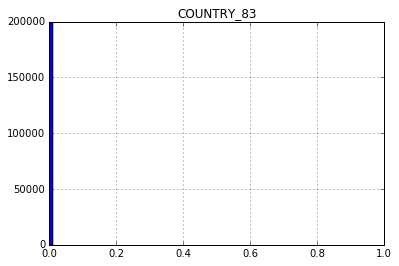

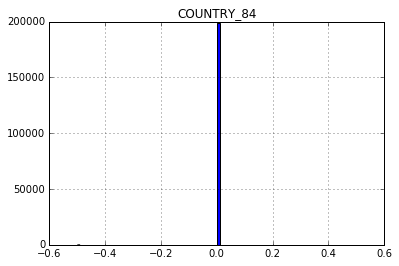

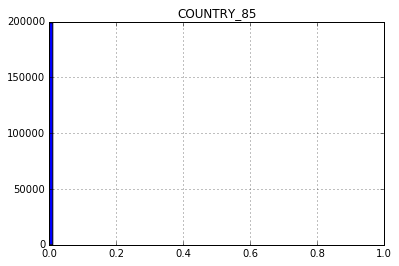

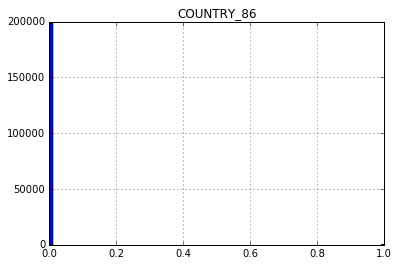

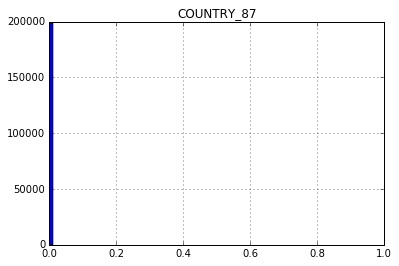

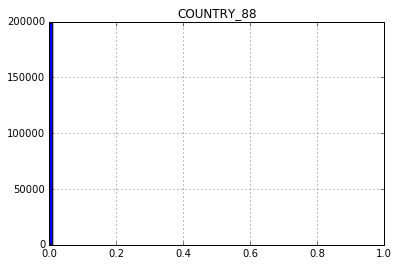

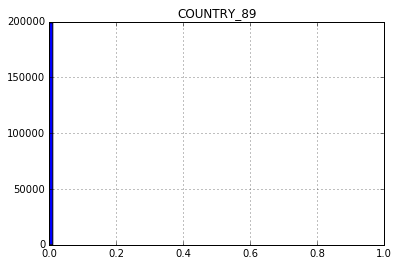

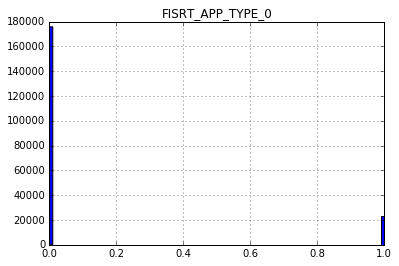

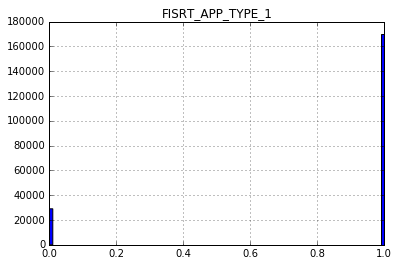

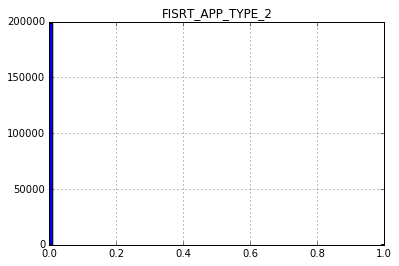

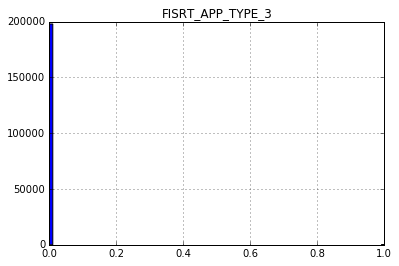

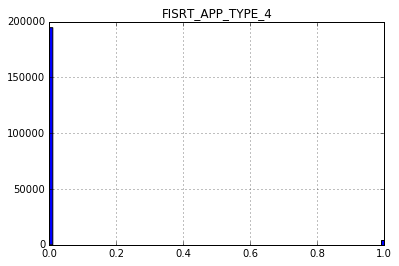

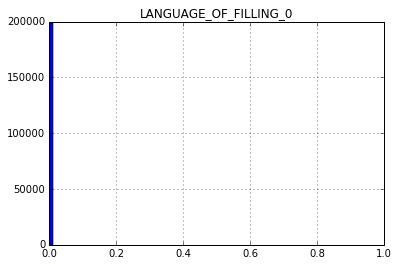

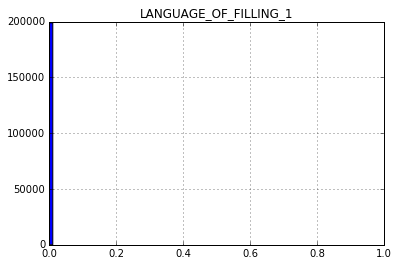

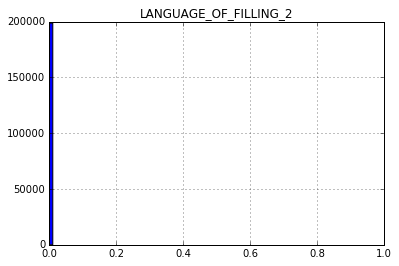

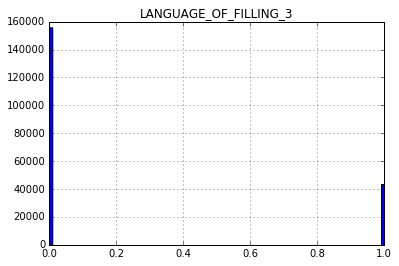

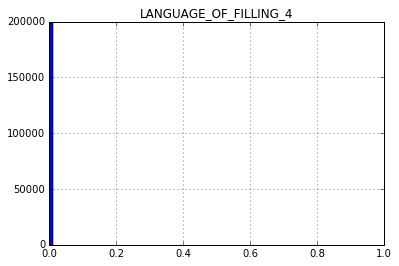

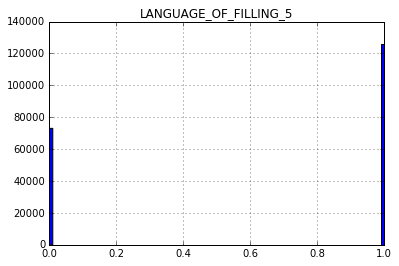

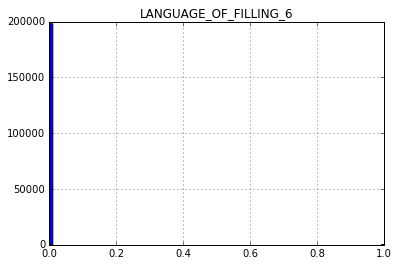

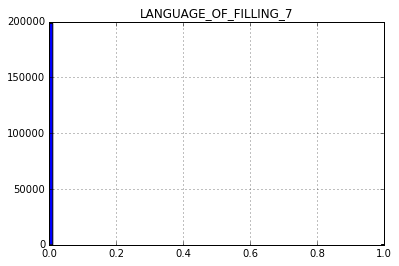

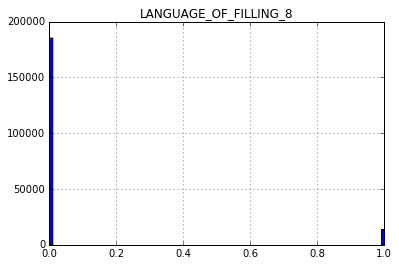

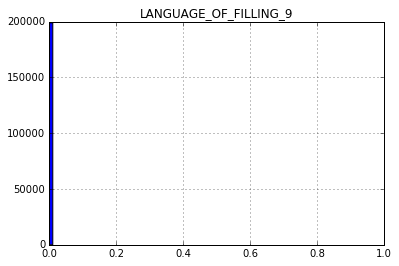

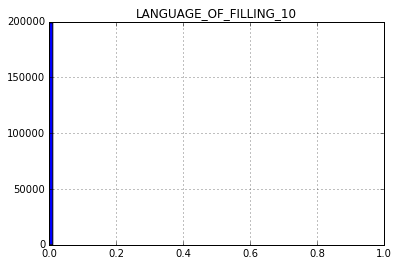

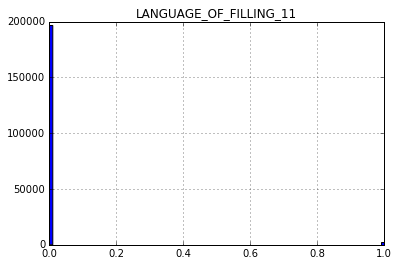

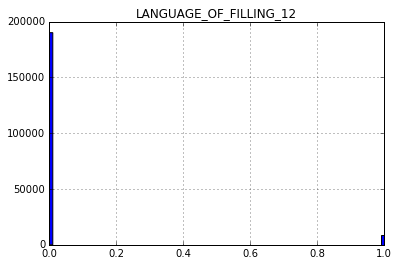

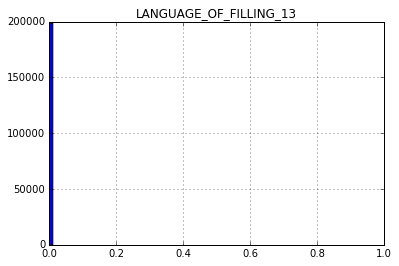

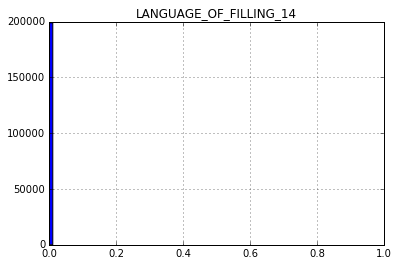

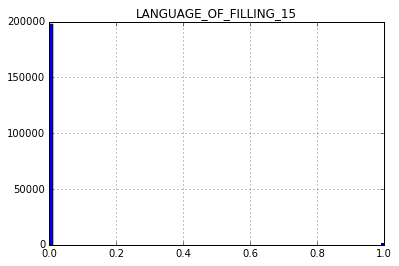

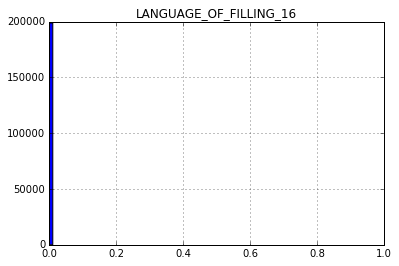

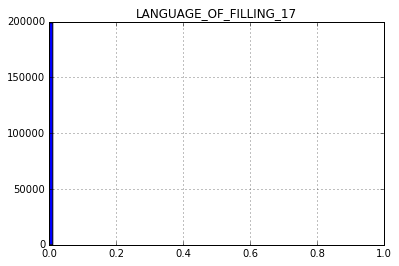

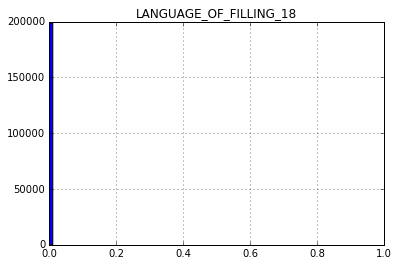

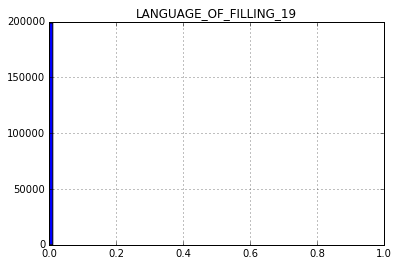

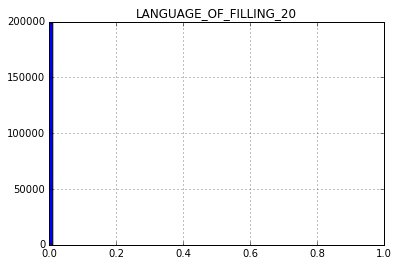

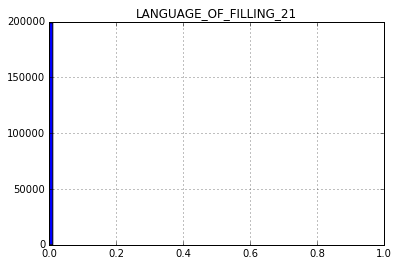

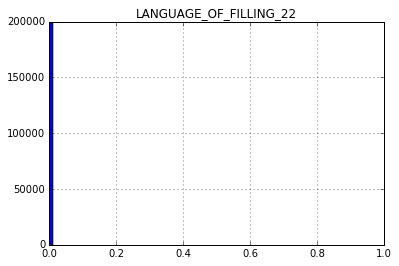

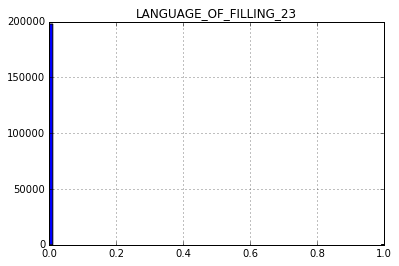

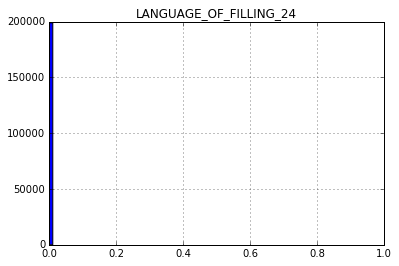

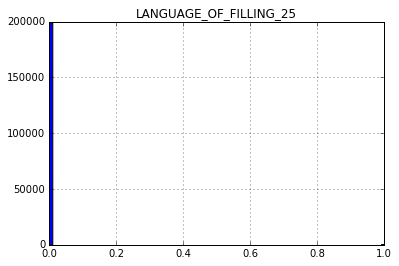

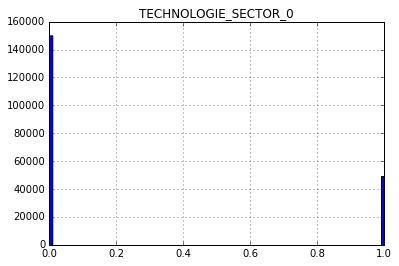

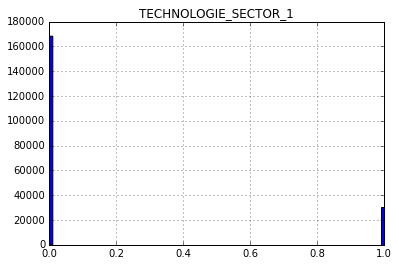

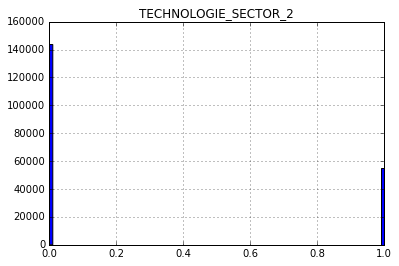

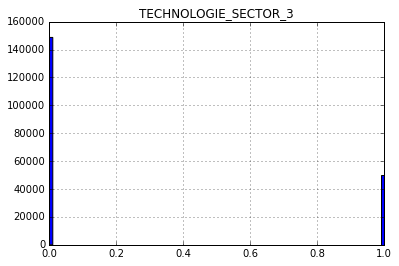

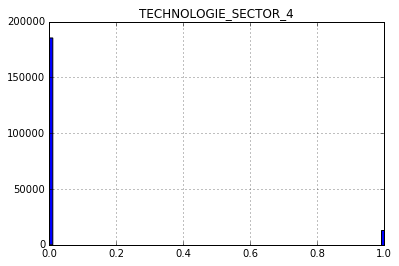

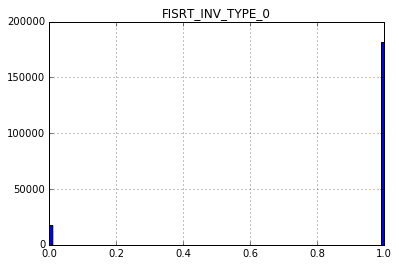

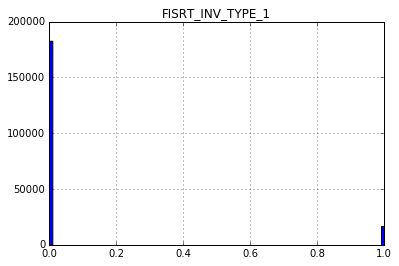

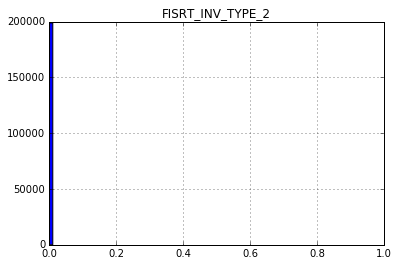

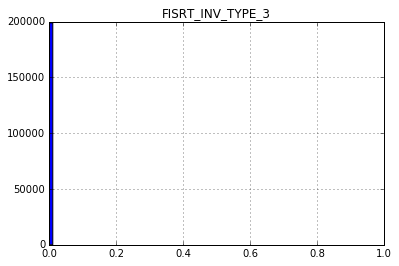

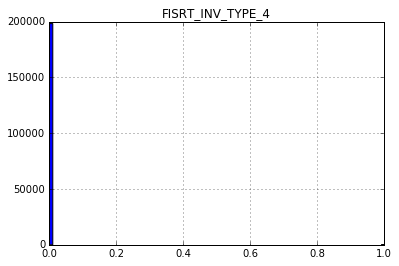

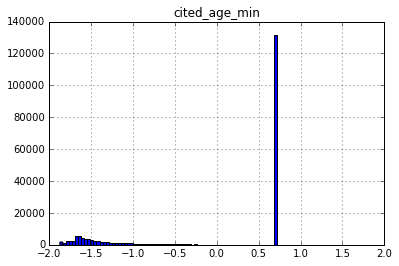

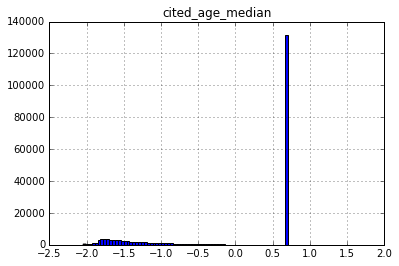

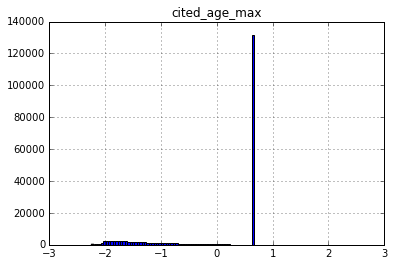

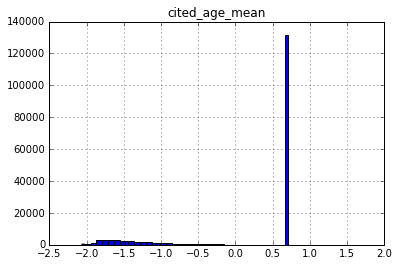

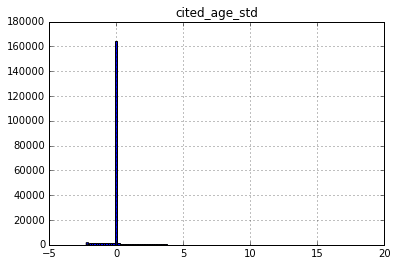

In [36]:
for col in df.columns:
    df.hist(col, bins=100)

# Training decision trees

In [38]:
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus

In [ ]:
max_depth = 3
min_samples_leaf = 5

clf = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
clf.fit(X_train, Y_train)

In [ ]:
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=Xcolumns,
                         class_names=['GRANTED', 'NOT GRANTED'],
                         filled=True, rounded=True,  
                         special_characters=True)  

content = dot_data.getvalue()
graph = pydotplus.graph_from_dot_data(content)  
Image(graph.create_png())  

In [ ]:
Y_pred = clf.predict(X_test)
Y_proba = clf.predict_proba(X_test)
print(Y_proba)

In [ ]:
plot_roc(Y_test, Y_proba[:,1])


In [155]:
max_depth = 30

roc_score = []
for i in range(1,max_depth):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, Y_train)
    
    Y_proba = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(Y_test, Y_proba[:,1])
    roc_score.append(roc_auc)

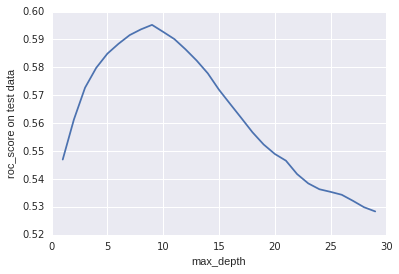

In [156]:
plt.plot(range(1,max_depth), roc_score)
plt.xlabel('max_depth')
plt.ylabel('roc_score on test data')

# Training Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
estimator = RandomForestClassifier(n_estimators=20, random_state=42)
paramters = {'max_depth':[10,20],'max_features':[100,150], 'min_samples_split':[50,200]}

clf = GridSearchCV(estimator, param_grid=paramters, n_jobs=1, cv=3, iid=True, verbose=3, scoring='roc_auc')

clf.fit(X_train, Y_train)

In [ ]:
clf.best_params_
# {'max_depth': 10, max_features': 100, 'min_samples_split': 50}

In [ ]:
Y_proba = clf.predict_proba(X_test)

plot_roc(Y_test, Y_proba[:,1])

In [ ]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=12, max_features=169, min_samples_split=1)
clf.fit(X_train, Y_train)

Y_proba = clf.predict_proba(X_test)
plot_roc(Y_test, Y_proba[:,1])

# Training Logistic regression

In [158]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier

In [171]:
penalization = np.logspace(-15,10,10)
print(penalization)

roc_score = []
for pen in penalization:
    clf = LogisticRegression(C=pen)
    clf.fit(X_train,Y_train)
    
    Y_proba = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(Y_test, Y_proba[:,1])
    roc_score.append(roc_auc)
    

[  1.00000000e-15   5.99484250e-13   3.59381366e-10   2.15443469e-07
   1.29154967e-04   7.74263683e-02   4.64158883e+01   2.78255940e+04
   1.66810054e+07   1.00000000e+10]


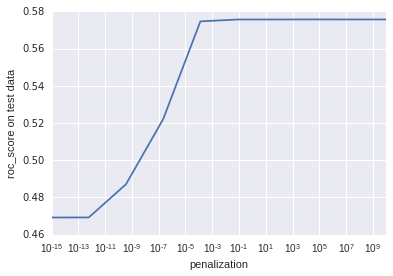

In [172]:
plt.semilogx(penalization, roc_score)
plt.xlabel('penalization')
plt.ylabel('roc_score on test data')

# reduction

In [173]:
from sklearn import manifold

In [174]:
data = X_train

isomap = manifold.Isomap(n_components=2,n_neighbors=5)

data = isomap.fit_transform(data)

MemoryError: 